# Core Workflow: Preparing Ground-truth Files
Transforms the LULC polygons provided by the Atlas of Urban Expansion into raster data that can be combined with imagery and/or other remote sensing inputs to create machine learning training data.  
  
Date: 2018-09-14  
Author: Peter Kerins

### Import statements
(may be over-inclusive)

In [1]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler 
import ogr, gdal
from keras.models import load_model
import math
from keras.utils import to_categorical
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.utils import to_categorical
from skimage import measure
from skimage import filters
from scipy import stats

import tensorflow as tf
import keras

import collections

import descarteslabs as dl
print dl.places.find('illinois') ## TEST

# how do change this from manual?
sys.path.append('/home/Peter.Kerins/UrbanLandUse/utils')
print sys.path

import util_descartes
import util_ml
import util_rasters
import util_vectors
import util_workflow


Using TensorFlow backend.


[{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Peter.Kerins/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Peter.Kerins/.ipython', '/home/Peter.Kerins/UrbanLandUse/utils']


### Set key variables

In [2]:
place = 'sitapur'

data_root='/data/steven/data/'
data_path=data_root+place+'/'

# replace with sentinel-2 ids from the project imagery catalog
# any list of image ids is fine, provided that collectively it covers the full study area
vir_ids = [u'sentinel-2:L1C:2017-02-23_44RMR_82_S2A_v1']

tile_resolution = 10
tile_size = 256
tile_pad = 16

# ground truth source: labels, aue+osm, aue+osm2
label_suffix = 'aue'

# NYU AoUE land use/land cover categories
category_label = {0:'Open Space',1:'Non-Residential',\
                   2:'Residential Atomistic',3:'Residential Informal Subdivision',\
                   4:'Residential Formal Subdivision',5:'Residential Housing Project',\
                   6:'Roads',7:'Study Area',8:'Labeled Study Area',254:'No Data',255:'No Label'}

### Load and inspect study area

sitapur Sitapur
>>> ogrinfo -al -so /data/steven/data/sitapur/Sitapur_studyArea.shp
INFO: Open of `/data/steven/data/sitapur/Sitapur_studyArea.shp'
      using driver `ESRI Shapefile' successful.

Layer name: Sitapur_studyArea
Metadata:
  DBF_DATE_LAST_UPDATE=2016-07-18
Geometry: Polygon
Feature Count: 1
Extent: (452962.901712, 3030448.248706) - (484367.511519, 3076769.642552)
Layer SRS WKT:
PROJCS["WGS_1984_UTM_Zone_44N",
    GEOGCS["GCS_WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS_84",6378137.0,298.257223563]],
        PRIMEM["Greenwich",0.0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["false_easting",500000.0],
    PARAMETER["false_northing",0.0],
    PARAMETER["central_meridian",81.0],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["latitude_of_origin",0.0],
    UNIT["Meter",1.0]]
Id: Integer (6.0)

>>> ogrinfo -al -so /data/steven/data/sitapur/Sitapur_studyAreaEPSG4326.shp
INFO: Open of `/data/steven/data

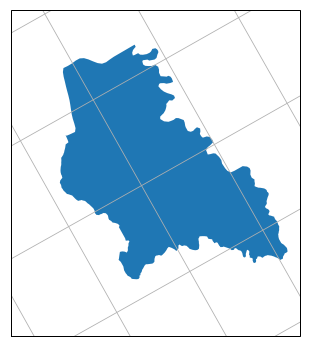

In [3]:
print place, place.title() # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

util_vectors.info_studyareas(data_path, place)

shape = util_vectors.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
#print polygon
#pprint(shape)
place_bbox = shape['bbox']
#print bbox

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (place_bbox[0]+place_bbox[2])/2.0, (place_bbox[1]+place_bbox[3])/2.0
print "center co-ordinates", clat, clon
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((place_bbox[0], place_bbox[2], place_bbox[1], place_bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 164
[u'geometry', u'type', u'properties']
tile022 {u'type': u'Polygon', u'coordinates': [[[80.58371839158306, 27.493086607634652], [80.61287374148236, 27.49317076023959], [80.61278273896824, 27.519170638458057], [80.58362053593041, 27.519086392999938], [80.58371839158306, 27.493086607634652]]]}


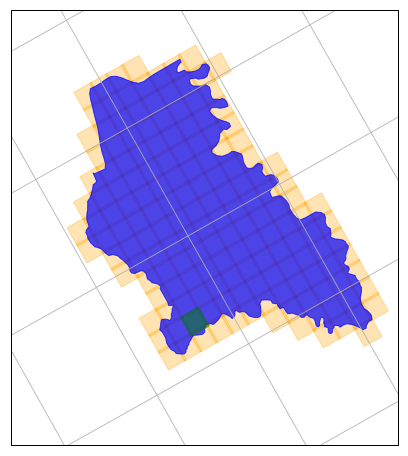

In [4]:
tiles = dl.raster.dltiles_from_shape(tile_resolution, tile_size, tile_pad, shape)
single_tile_id = 22
highlights = {single_tile_id:'green'}
util_vectors.draw_tiled_area(shape, tiles, albers, lonlat_crs, highlights=highlights)

### Create ground-truth raster tiles
For each tile, creates a blank GeoTiff file and subsequently "burns" into it values from the (already prepared) GeoJSON file holding the AUE LULC polygons, thereby "rasterizing" the vector ground-truth data into a format amenable to machine learning: individual pixels in imagery can now be associated with specific LULC categories.

In [5]:
reload(util_descartes)

for tile_id in range(len(tiles['features'])):
    tile = tiles['features'][tile_id]
    util_descartes.make_label_raster(data_path, place, tile_id, tile, vir_ids, shape,
        bands=['alpha'], label_suffix='aue', vector_format='geojson')

imgfile /data/steven/data/sitapur/sitapur_tile000_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile000_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/steven/data/sitapur/sitapur_tile001_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile001_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/steven/data/sitapur/sitapur_tile002_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile002_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/steven/data/sitapur/sitapur_tile003_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile003_aue.tif
0...10...20...

>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile032_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/steven/data/sitapur/sitapur_tile033_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile033_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/steven/data/sitapur/sitapur_tile034_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile034_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/steven/data/sitapur/sitapur_tile035_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile035_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfil

>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile064_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/steven/data/sitapur/sitapur_tile065_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile065_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/steven/data/sitapur/sitapur_tile066_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile066_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/steven/data/sitapur/sitapur_tile067_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile067_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfil

>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile096_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/steven/data/sitapur/sitapur_tile097_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile097_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/steven/data/sitapur/sitapur_tile098_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile098_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/steven/data/sitapur/sitapur_tile099_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile099_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfil

>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile128_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/steven/data/sitapur/sitapur_tile129_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile129_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/steven/data/sitapur/sitapur_tile130_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile130_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/steven/data/sitapur/sitapur_tile131_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile131_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfil

>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile160_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/steven/data/sitapur/sitapur_tile161_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile161_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/steven/data/sitapur/sitapur_tile162_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile162_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/steven/data/sitapur/sitapur_tile163_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/steven/data/sitapur/Sitapur_Complete.geojson /data/steven/data/sitapur/sitapur_tile163_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

